In [50]:
import io
from collections import Counter

import numpy as np
import pandas as pd
import scipy.io
from statistics import mode
import sklearn.model_selection
import sklearn.tree
import seaborn as sns

from fairlearn.widget import FairlearnDashboard
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate

import pydot
import multiprocessing as mp
from sklearn.feature_extraction import DictVectorizer

In [2]:
df_por, df_mat = pd.read_csv('student-por.csv', sep=';'), pd.read_csv('student-mat.csv', sep=';')

Index:
[grade distribution](#gradedist)<br>
[decision tree](#tree)<br>
[Attributes](#attribute)<br>
[pivot+heatmap](#pivot)<br>

# Subjects and Grades

## [Dataset Description](https://archive.ics.uci.edu/ml/datasets/Student+Performance)

Two seperate data set. Math + Portugees.[grade distribution](#gradedist)

### these grades are related with the course subject, Math or Portuguese:
31 G1 - first period grade (numeric: from 0 to 20) <br>
31 G2 - second period grade (numeric: from 0 to 20) <br>
32 G3 - final grade (numeric: from 0 to 20, output target) <br>

<font color=red size=3.3>Question: </font>
- Which dataset?
    - Focusing on one: straight forward. Less 
    - Math and Portuguese? (The populations are **different**)
        - What's the point of doing this?
        - Different bias in different subjects. <font color=red>(TBD)</font>
    
- How to deal with G1, G2 (two midterms) and G3?
    - Having a <font color=blue>Pass/No Pass</font> option.(default option?)
    - Having <font color=blue>four letter grads. A/B/C/F.</font>
        - Provide functions for participants to seperate the letter grades. 
    - <font color=blue>Regression</font>
        - Low Accuracy/High Accuracy but overfitting. 
    - Having them come up with their own ideas on how to evaluate the grade.


In [20]:
# Define the criteria of failing/passing.

def generate_pnp(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Augmented the original dataframe with a "pass" column.
    """    
    # Sanity Check.
    assert g_1 + g_2 + g_3 == 1, "The sum of percentages should be 1"
    assert 0 < threshold < 20, "Threshold need to be between 0 and 20"
    
    # Augmenting the dataframe.
    df['pass'] = df.apply(lambda row: 1 
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
    
def generate_letter(df, g_1=0.3, g_2=0.3, g_3=0.4, A=17, B=15, C=11):
    """
    Augmented the dataframe with a "letter" column.
    """    
    # Sanity Check.
    assert g_1 + g_2 + g_3 == 1, "The sum of percentages should be 1"
    assert (A < 20 and C > 0 and A > B > C), "Grade Bin errors"
    
    # 
    ### TODO: Agumenting the dataframe.###
    #

In [3]:
df_por.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
451,MS,M,16,R,GT3,T,1,2,other,other,...,4,3,3,1,1,5,0,10,11,11
34,GP,M,16,U,GT3,T,3,2,other,other,...,5,4,3,1,1,5,4,12,12,12
474,MS,M,15,R,LE3,T,1,3,at_home,other,...,4,2,4,3,5,3,2,10,11,11
27,GP,M,15,U,GT3,T,4,2,health,services,...,2,2,4,2,4,1,0,11,11,11
513,MS,F,16,U,GT3,T,3,1,other,other,...,3,1,3,1,3,1,0,8,6,8


In [4]:
df_mat.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
172,GP,M,17,U,LE3,T,4,4,teacher,other,...,4,4,4,1,3,5,0,13,11,10
167,GP,F,16,U,GT3,T,4,2,health,services,...,4,2,3,1,1,3,0,14,15,16
386,MS,F,18,R,GT3,T,4,4,teacher,at_home,...,4,4,3,2,2,5,7,6,5,6
86,GP,F,16,U,LE3,T,2,2,at_home,other,...,4,3,4,1,2,2,4,8,7,6
156,GP,M,17,R,LE3,T,1,2,other,other,...,2,2,2,3,3,5,8,16,12,13


<a id="gradedist">Grade distributions</a>

/Users/wesley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


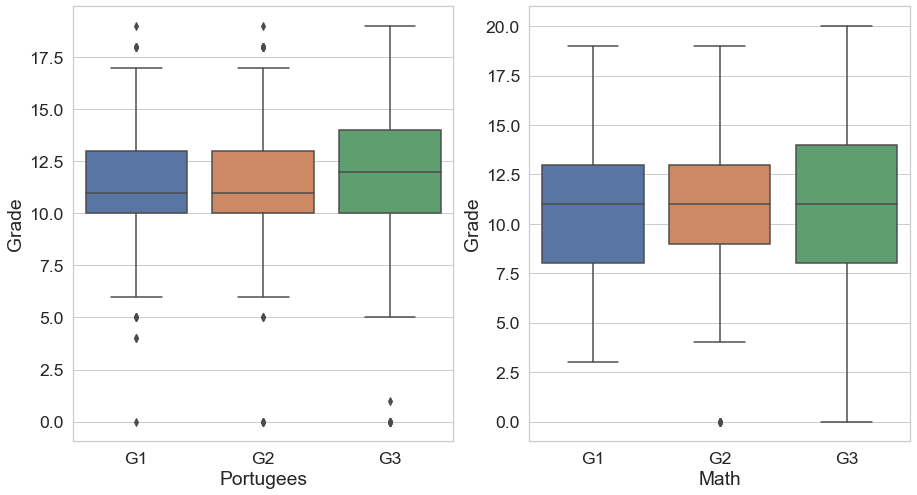

In [19]:
# Creating side by side box plot for the grades. 
import matplotlib.pyplot as plt
#ax = sns.swarmplot(x="variable", y="value", data=pd.melt(df))
#fig.set_axis_labels('Exam Type', 'Grade')

sns.set(rc={'figure.figsize':(15,8)}, font_scale=1.6)
sns.set_style('whitegrid')
mat_grad = df_mat[['G1', 'G2', 'G3']]
por_grad = df_por[['G1', 'G2', 'G3']]

fig, ax = plt.subplots(1, 2)
#ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))

sns.boxplot(x="variable", y="value", data=pd.melt(por_grad), ax=ax[0])
ax[0].set(xlabel='Portugees', ylabel='Grade')

sns.boxplot(x="variable", y="value", data=pd.melt(mat_grad), ax=ax[1])
ax[1].set(xlabel='Math', ylabel='Grade')

#fig = ax.get_figure()

fig.show();

### In general:

Math test has a lower mean and higher sd. Especially for G3, the final.

|Math  |G1|G2|G3|
|------|------|------|------|
|mean  |10.908861     |10.713924     |10.415190     |
|sd    |3.319195     |3.761505     |4.581443     |

Portuguese

|Portugese  |G1|G2|G3|
|------|------|------|------|
|mean  |11.399076|11.570108|11.906009|
|sd    |2.745265|2.913639|3.230656|

In [5]:
df_mat.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [6]:
df_por.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


**Question** How to seperate the G1, G2, G3?
- Having a Pass/No Pass option.
- Having four letter grads. A/B/C/F.
        - Write functions for participants to seperate the letter grades. 
- Having them come up with their own ideas on how to evaluate the grade.
- Math and Portuguese, cross comparation? (The populations are **different**)
        - What's the point of doing this?
        - Different bias in different subjects.

In [7]:
print(df_por.shape, df_mat.shape)

(649, 33) (395, 33)


<a id="attribute">Understanding the attributes</a>
## Understanding the Attributes

**Observation before analysis.** (Mimicing the real world analysis: Passi and Barocas, 2019)<br>
<font color=red>red</font>: hypothetical sensitive features. <br>
<font color=blue>green</font>: hypothetical high correlation. <br>

1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira) <br>
2 <font color=red>sex - student's sex</font> (binary: 'F' - female or 'M' - male)<br>
3 <font color=red>age - student's age</font> (numeric: from 15 to 22)<br>
4 address - student's home address type (binary: 'U' - urban or 'R' - rural)<br>
5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)<br>
6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)<br>
7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)<br>
8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)<br>
9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')<br>
10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')<br>
11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')<br>
12 guardian - student's guardian (nominal: 'mother', 'father' or 'other')<br>
13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)<br>
14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)<br>
15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)<br>
16 schoolsup - extra educational support (binary: yes or no)<br>
17 famsup - family educational support (binary: yes or no)<br>
18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)<br>
19 activities - extra-curricular activities (binary: yes or no)<br>
20 nursery - attended nursery school (binary: yes or no)<br>
21 higher - wants to take higher education (binary: yes or no)<br>
22 <font color=blue>internet - Internet access at home</font> (binary: yes or no)<br>
23 romantic - with a romantic relationship (binary: yes or no)<br>
24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)<br>
25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)<br>
26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)<br>
27 <font color=blue>Dalc - workday alcohol consumption</font> (numeric: from 1 - very low to 5 - very high)<br>
28 <font color=blue>Walc - weekend alcohol consumption</font> (numeric: from 1 - very low to 5 - very high)<br>
29 health - current health status (numeric: from 1 - very bad to 5 - very good)<br>
30 absences - number of school absences (numeric: from 0 to 93)<br>


Potential next step if we decided to use this dataset:
- What are the proxies?
    - `School` with `Medu`, `Fedu`, `Mjob`, `Fjob`, `reason`, 
- Statistical analysis (Chi-square) for the attributes.
- Understanding the potential bias under the constraints of:
    - 

## Takeaways: Traditional EDA vs. Debiasing. 


When is the *right timing* to shift from EDA to using the FairLearn? <br>

Conflating the concept of correlation vs potential biased attributes. <br>

What *are* sensitive/protected attributes anyway? `studytime` doesn't seem like one but `famsup` sounds like one. But I would say this two are correlated?

What's the relationship among different features? Are there any proxies? How should we choose the sensitive_feature <br>

In [8]:
numerical_features = df_por.select_dtypes(include=['int64', 'float64']).columns.values
numerical_features

array(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'G3'], dtype=object)

In [9]:
# Get different type of features. Features are same for both mat and por. 
categorical_features = df_por.select_dtypes(include=['object']).columns.values
categorical_features

array(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'], dtype=object)

In [10]:
# One_hot_encoding
df_por_encoding = pd.get_dummies(df_por, columns=categorical_features)
df_mat_encoding = pd.get_dummies(df_mat, columns=categorical_features)

In [11]:
df_por_encoding.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R',
       'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'schoolsup_no', 'schoolsup_yes',
       'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'activities_no',
       'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no',
       'higher_yes', 'internet_no', 'internet_yes', 'romantic_no',
       'romantic_yes'],
      dtype='object')

# Generating the threshold

In [43]:
# Define the criteria of failing/passing.

def generate_pnp(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Augmented the original dataframe with a "pass" column.
    """    
    # Sanity Check.
    assert g_1 + g_2 + g_3 == 1, "The sum of percentages should be 1"
    assert 0 < threshold < 20, "Threshold need to be between 0 and 20"
    
    # Augmenting the dataframe.
    df['pass'] = df.apply(lambda row: 1 
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
    
def generate_letter(df, g_1=0.3, g_2=0.3, g_3=0.4, A=17, B=15, C=11):
    """
    Augmented the dataframe with a "letter" column.
    """    
    # Sanity Check.
    assert g_1 + g_2 + g_3 == 1, "The sum of percentages should be 1"
    assert (A < 20 and C > 0 and A > B > C), "Grade Bin errors"
    
    # 
    ### TODO: Agumenting the dataframe.###
    #

In [23]:
generate_pnp(df_por_encoding)

In [24]:
ax = df_por_encoding['pass'].value_counts()
ax

1    384
0    265
Name: pass, dtype: int64

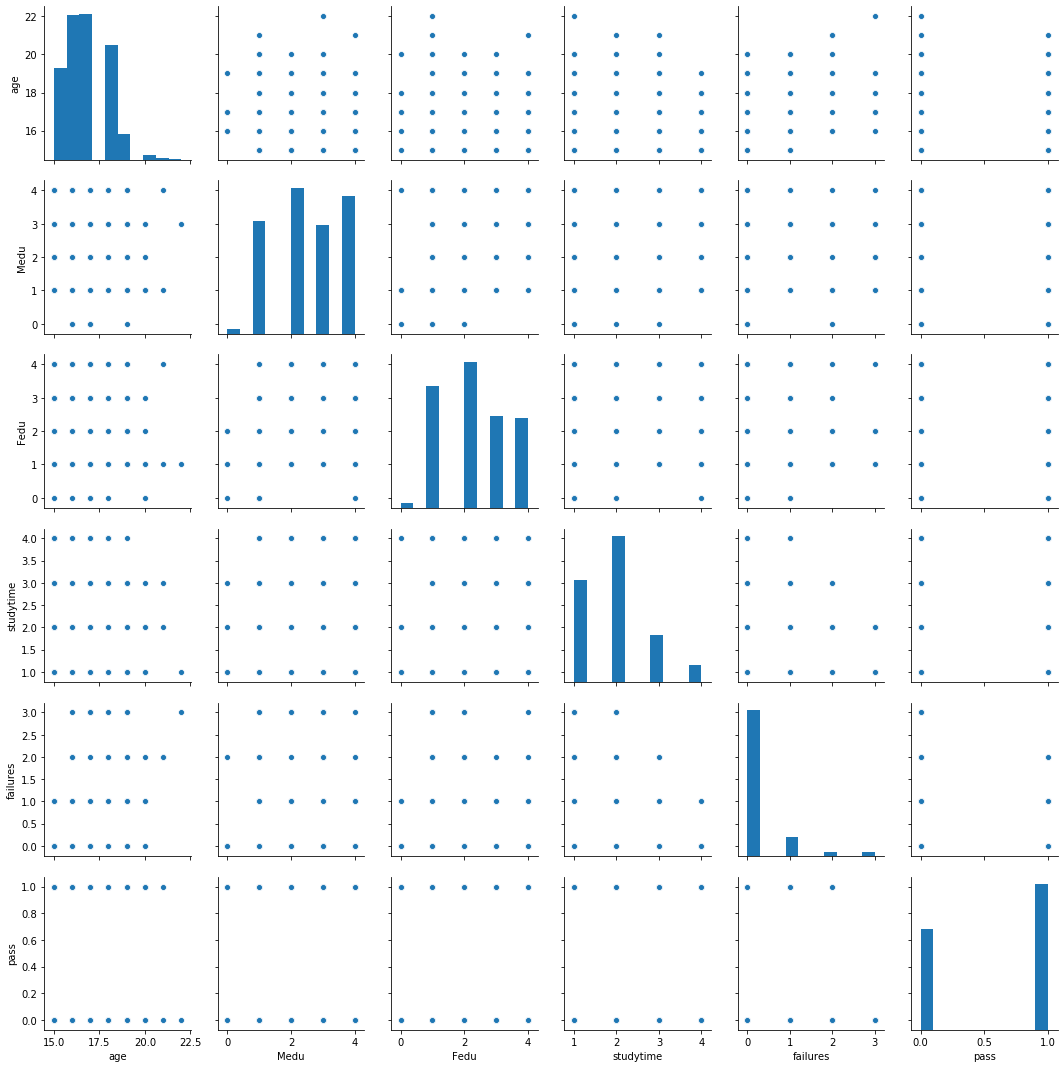

In [36]:
sns.pairplot(data=df_por_encoding[['age', 'Medu', 'Fedu', 'studytime', 'failures', 'pass']]);

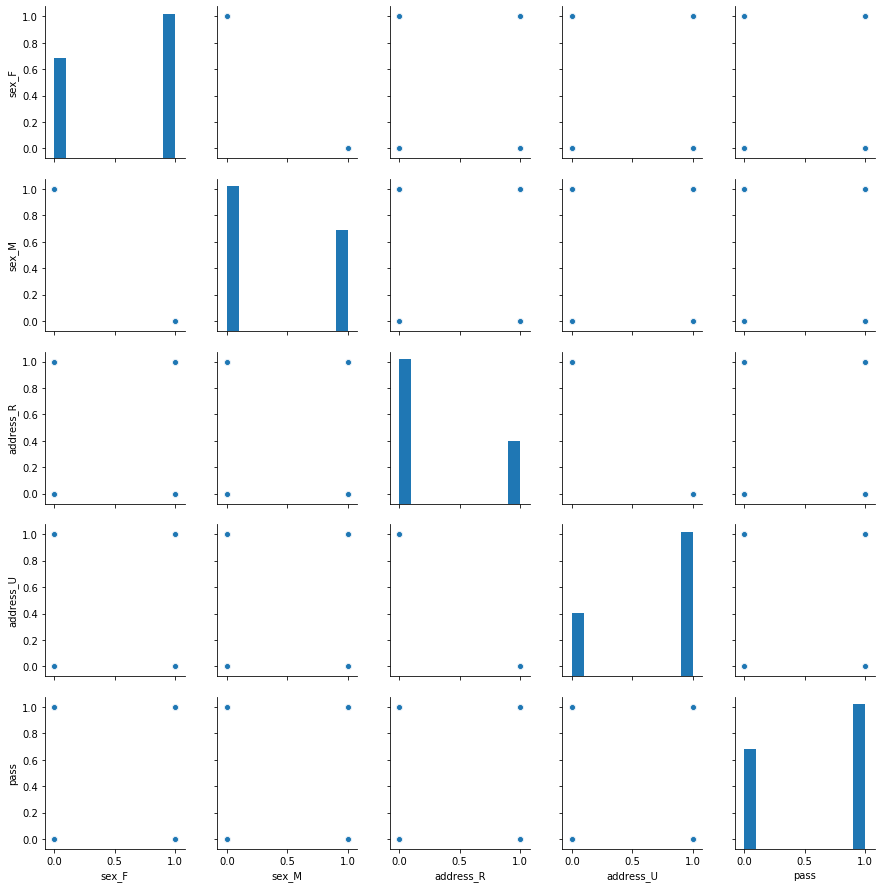

In [37]:
sns.pairplot(data=df_por_encoding[['sex_F', 'sex_M', 'address_R', 'address_U', 'pass']]);

<a id="pivot">pivot/heatmap</a>
<font size=3.3>

Note: the visualization is not super helpful for discrete dataset. <br>
**Question**: Should we gave them example of EDA? --> Depend on how experienced they are? <br>
Maybe having them conduct EDA at home as well? <br>
Training, EDA all before the interview, coming in with prior knowledge.

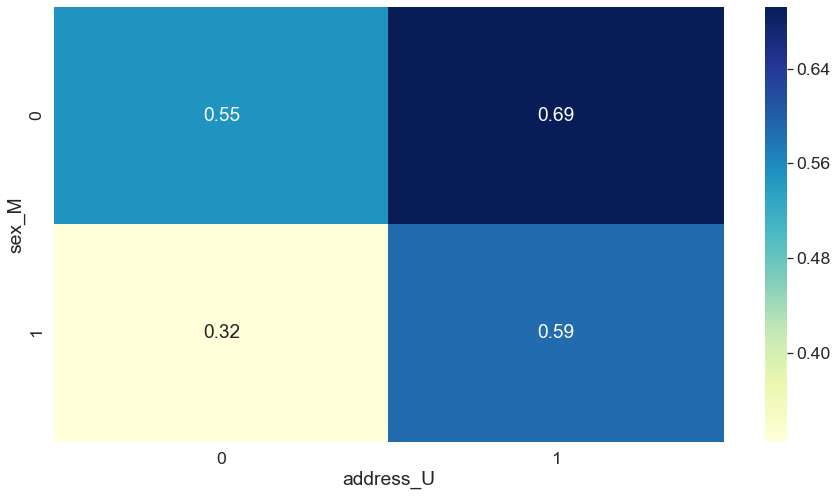

In [30]:
sex_address = pd.pivot_table(df_por_encoding, values = 'pass', index = 'sex_M', columns = 'address_U')
ax = sns.heatmap(sex_address, annot=True, cmap="YlGnBu");

In [50]:
df_por_encoding[['sex_M', 'pass','address_U']].sample(5)

,sex_M,pass,address_U
222,0,1,1
569,1,0,1
329,0,1,1
276,1,1,1
376,0,1,1


In [26]:
df_por_encoding.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R',
       'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'schoolsup_no', 'schoolsup_yes',
       'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'activities_no',
       'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no',
       'higher_yes', 'internet_no', 'internet_yes', 'romantic_no',
       'romantic_yes', 'pass'],
      dtype='object')

### Decision Tree and Random Forest 



In [31]:
from sklearn.model_selection import train_test_split
df_por_new = df_por_encoding.drop(['G1', 'G2', 'G3'], axis=1)
y = df_por_new['pass']
X = df_por_new.drop(['pass'], axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

In [33]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(486, 56) (163, 56) (486,) (163,)


In [35]:
from sklearn import tree
t_single = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
t_single = t_single.fit(X_train, y_train)

In [67]:
tree.export_graphviz(t_single, out_file = 'sample_tree.dot', label='all', impurity=False, proportion=True,
                    feature_names=list(X_train), class_names=['fail', 'pass'], filled=True, rounded=True)

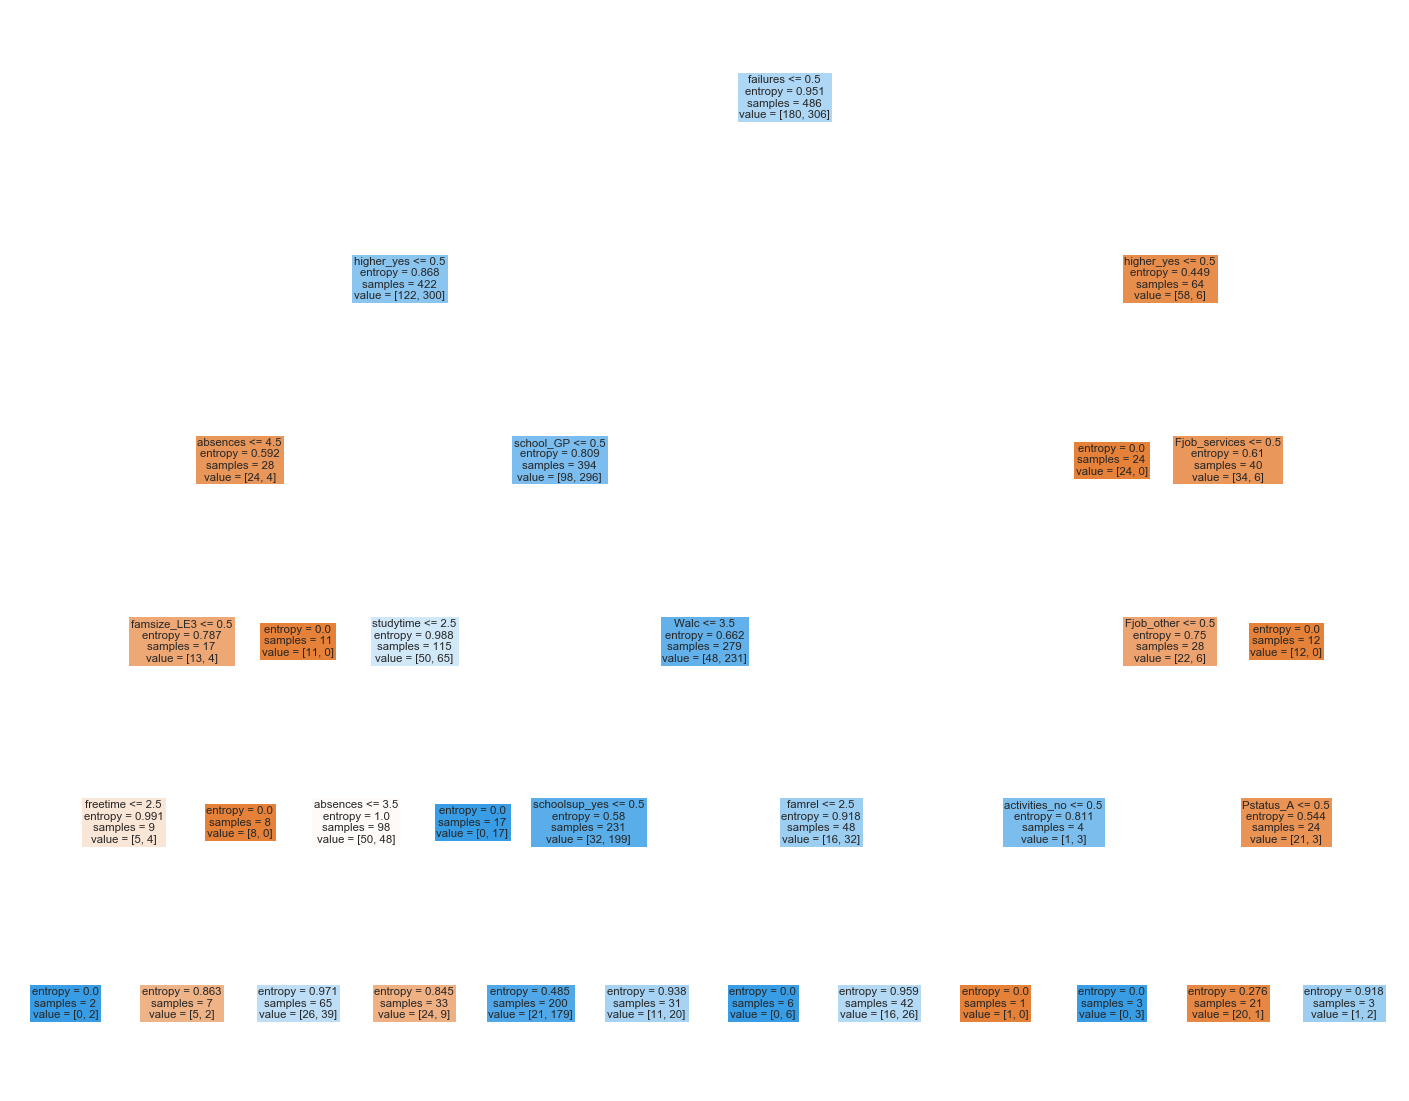

In [42]:
fig = plt.figure(figsize=(25,20))
ax = tree.plot_tree(t_single, feature_names = X_train.columns, 
                   filled=True)
fig.savefig('single_tree.png')

In [36]:
t_single.score(X_test, y_test)

0.6871165644171779

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=6, random_state=15)
forest = forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.7239263803680982

In [7]:
# SHAP for model explaination.

import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

**Potential Biased Attribute**
- Address: Urban vs. Rural. 


## A Fairlean "baseline" practice

Link to secound notebook.

## Next Step

<font size=3.3>
<br>
    
1. Run a more involved version for [multiple features](https://fairlearn.github.io/v0.5.0/auto_examples/plot_new_metrics.html) 
<br>


2. More in-depth understanding of the features and decide which to keep.
<br>

3. Looking into how to fit the dataset into AIF360? <br>